# Wikipedia2014 + Gigaword5 and GloVe
ref: https://nlp.stanford.edu/projects/glove/

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config = config)

from keras.datasets import reuters
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, Reshape, Bidirectional, Conv2D, MaxPool2D, Concatenate, Activation
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 300
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 300

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.decomposition import PCA

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
glove_file = datapath('/workspace/2018_data_science/word2vec/model/glove.6B/glove.6B.300d.txt')
tmp_file = get_tmpfile("word2vec.6B.300d.txt")

glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [3]:
type(model['animal']), model['animal'].shape, model['animal']

(numpy.ndarray,
 (300,),
 array([ 0.25653  ,  0.66592  , -0.5313   ,  0.20342  ,  0.40049  ,
        -0.23473  ,  0.09909  ,  0.057834 , -0.12077  , -1.1298   ,
         0.35164  , -0.3265   , -0.66833  ,  0.18788  ,  0.22281  ,
         0.054691 ,  0.025744 ,  0.31266  , -0.28724  ,  0.23793  ,
        -0.040331 ,  0.32854  ,  0.22044  ,  0.45647  , -0.37563  ,
         0.43402  ,  0.38154  , -0.35248  ,  0.19495  ,  0.4076   ,
        -0.37865  ,  0.23548  , -0.84291  , -0.49411  ,  0.052115 ,
        -0.16012  ,  0.64314  ,  0.30405  , -0.43855  , -0.24154  ,
        -0.24044  , -0.23007  ,  0.1408   , -0.53307  , -0.5172   ,
        -0.064734 , -0.12548  ,  0.078003 ,  0.36785  ,  0.24616  ,
        -0.16876  ,  0.50944  , -0.055875 ,  0.11483  ,  0.29215  ,
        -0.029616 ,  0.094811 ,  0.024069 , -0.63261  , -0.40383  ,
        -0.20841  ,  0.039754 ,  0.58189  ,  0.11466  , -0.335    ,
        -0.27225  , -0.2824   , -0.5118   ,  0.22429  ,  0.456    ,
        -0.15358  ,  0.

In [4]:
model.similar_by_vector(model['france'], topn = 10, restrict_vocab = None)

[('france', 1.0),
 ('french', 0.7344760894775391),
 ('paris', 0.6580672264099121),
 ('belgium', 0.620672345161438),
 ('spain', 0.573593258857727),
 ('italy', 0.5643459558486938),
 ('germany', 0.5567397475242615),
 ('prohertrib', 0.5564222931861877),
 ('britain', 0.5553334951400757),
 ('chirac', 0.5362644195556641)]

In [5]:
model.most_similar(positive = ['woman', 'king'], negative = ['man'])

[('queen', 0.6713277101516724),
 ('princess', 0.5432624220848083),
 ('throne', 0.5386104583740234),
 ('monarch', 0.5347574949264526),
 ('daughter', 0.498025119304657),
 ('mother', 0.4956442713737488),
 ('elizabeth', 0.4832652509212494),
 ('kingdom', 0.47747087478637695),
 ('prince', 0.4668239951133728),
 ('wife', 0.4647327661514282)]

In [6]:
model.doesnt_match('breakfast cereal dinner lunch'.split())

'cereal'

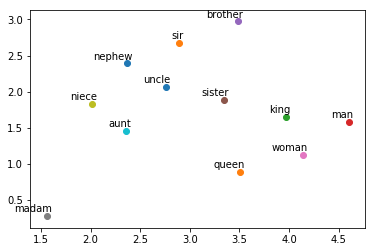

In [7]:
def pca_plot(model):
    labels = []
    tokens = []

    for word in model.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = PCA(n_components = 2)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    for i in range(len(x)):
        label = labels[i]
        if label in ['king', 'queen', 'sister', 'brother', 'niece', 'nephew', 'aunt', 'uncle', 'woman', 'man', 
                     'madam', 'sir']:
            plt.scatter(x[i],y[i])
            plt.annotate(label,
                         xy = (x[i], y[i]),
                         xytext = (5, 2),
                         textcoords = 'offset points',
                         ha = 'right',
                         va = 'bottom')
    plt.show()

pca_plot(model)

# Reuter-21578 Data set with word2vec
Last week, you have already worked on Reuters-21578 dataset for multi-class classification. This week, you are using word2vec to classify the same dataset.

In this lab, you will have to implement 3 three neural network model using keras API:
1. Mutilayer perceptron
2. Conv1D
3. LSTM

In [8]:
# this requires download from the first time
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = MAX_NB_WORDS, 
                                                         skip_top = 0, 
                                                         maxlen = MAX_SEQUENCE_LENGTH,
                                                         seed = 113,
                                                         start_char = 1, 
                                                         oov_char = 2, 
                                                         index_from = 3)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

word2index = reuters.get_word_index()
word2index = {key : (value + 3) for (key, value) in word2index.items()}
word2index['<PAD>'] = 0
word2index['<START>'] = 1
word2index['<UNK>'] = 2

In [9]:
embeddings_index = {}
f = open(os.path.join('./model/glove.6B/', 'glove.6B.300d.txt'), encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word2index) + 1, EMBEDDING_DIM))
for word, i in word2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word2index) + 1,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable = False)

Found 400000 word vectors.


In [10]:
X_train = pad_sequences(X_train, maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen = MAX_SEQUENCE_LENGTH)

In [11]:
print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_test tensor:', X_test.shape)

# split the data into a training set and a validation set
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]
nb_validation_samples = int(VALIDATION_SPLIT * X_train.shape[0])

X_val = X_train[-nb_validation_samples:]
y_val = y_train[-nb_validation_samples:]
X_train = X_train[:-nb_validation_samples]
y_train = y_train[:-nb_validation_samples]

Shape of X_train tensor: (7976, 300)
Shape of X_test tensor: (1994, 300)


## word2vec + multiple layer perceptron

In [12]:
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(sequence_input)

x = Flatten()(embedded_sequences)
x = Dense(128)(x)
x = Activation('relu')(x)
# x = Dropout(0.2)(x)
x = Dense(64)(x)
x = Activation('relu')(x)
# x = Dropout(0.2)(x)
x = Dense(32)(x)
x = Activation('relu')(x)
# x = Dropout(0.2)(x)
x = Dense(46)(x)
preds = Activation('softmax')(x)

model = Model(sequence_input, preds)
print(model.summary())
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.fit(X_train, y_train, validation_data = (X_val, y_val),
          epochs = 20, batch_size = 256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          9294900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               11520128  
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

In [13]:
results = model.evaluate(X_test, y_test)
results

1994/1994 [==============================] - 0s 48us/step


[2.102050429002691, 0.6825476429287863]

## word2vec + Conv1D

In [14]:
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(64, 5, activation = 'relu')(embedded_sequences)
x = MaxPooling1D(5)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.2)(x)
preds = Dense(46, activation = 'sigmoid')(x)

model = Model(sequence_input, preds)
print(model.summary())
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.fit(X_train, y_train, validation_data = (X_val, y_val),
          epochs = 30, batch_size = 128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          9294900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 59, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3776)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3776)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                241728    
__________

In [15]:
results = model.evaluate(X_test, y_test)
results

1994/1994 [==============================] - 0s 62us/step


[1.5933833050512622, 0.7472417251755266]

## word2vec + LSTM

In [16]:
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(sequence_input)

units = 128
embedded_sequences = embedding_layer(sequence_input)
layer1 = LSTM(units,
    dropout = 0.2,
    recurrent_dropout = 0.2,
    return_sequences = False)
x = layer1(embedded_sequences)

final_layer = Dense(46, activation = 'softmax')
preds = final_layer(x)

model = Model(sequence_input, preds)
print(model.summary())
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.fit(X_train, y_train, validation_data = (X_val, y_val),
          epochs = 30, batch_size = 256)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 300)          9294900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_7 (Dense)              (None, 46)                5934      
Total params: 9,520,482
Trainable params: 225,582
Non-trainable params: 9,294,900
_________________________________________________________________
None
Train on 5584 samples, validate on 2392 samples
Epoch 1/30
5584/5584 [==============================] - 11s 2ms/step - loss: 2.6388 - acc: 0.3730 - val_loss: 2.0681 - val_acc: 0.4741
Epoch 2/30
5584/5584 [==============================] - 10s 2ms/step -

In [17]:
results = model.evaluate(X_test, y_test)
results

1994/1994 [==============================] - 6s 3ms/step


[0.7196521676531288, 0.8340020060778381]